In [1]:
%%capture
# !pip install datasets transformers peft torchmetrics

import os
import subprocess

import numpy as np

from random import sample
from IPython.display import clear_output
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
sns.set_theme()

os.environ["TOKENIZERS_PARALLELISM"] = (
    "false"  # безопасный способ избежать лишних предупреждений и проблем с многопоточностью при токенизации.
)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Датасет

В качестве датасета возьмем один из датасетов бенчмарка GLUE – [SST2](https://huggingface.co/datasets/glue/viewer/sst2) (Stanford Sentiment Treebank).

Датасет содержит 67 тысяч предложений с отзывами на фильмы, которые требуется классифицировать на положительные и отрицательные.


In [4]:
from datasets import load_dataset

train_dataset = load_dataset("glue", "sst2", split="train[:20000]")
valid_dataset = load_dataset("glue", "sst2", split="validation")

In [5]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [6]:
train_dataset[2]

{'sentence': 'that loves its characters and communicates something rather beautiful about human nature ',
 'label': 1,
 'idx': 2}

In [7]:
len(train_dataset) , len(valid_dataset)

(20000, 872)

### Инициализация токенизатора и модели

In [8]:
model_checkpoint = "gpt2"

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

1

In [9]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_checkpoint, num_labels=num_classes
        )
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(
        self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs
    ):
        out = self.model.transformer(
            input_ids=input_ids,
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
        ).last_hidden_state

        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]

        return self.model.score(out)

        @property
        def device(self):
            return next(self.model.parameters()).device

In [10]:
num_classes = 2
model = Model(tokenizer, num_classes)

In [11]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out_fea

In [12]:
sum(p.numel() for p in model.parameters())

124442112

#### Подготовка данных

In [13]:
batch_size = 128

In [14]:
train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, num_workers=8
)
valid_loader = DataLoader(
    valid_dataset, shuffle=False, batch_size=batch_size, num_workers=8
)

In [15]:
print("       0       1")

classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

       0       1
Train: 0.446 0.554
Valid: 0.491 0.509


### Train loop

In [16]:
model.to(device)

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out_fea

In [17]:
def training_loop_fn(
    model, opt, total_num_iters, eval_freq, train_loader, valid_loader
):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["sentence"], padding=True, return_tensors="pt")
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(
                    tokenized["input_ids"],
                    tokenized["attention_mask"],
                    return_dict=False,
                )
                targets = batch["label"].to(device)
                loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, "binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))
                model.train()

            if global_step % 250 == 0:                
                clear_output(True)
                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

            global_step += 1
            if global_step >= total_num_iters:
                break
        else:
            continue
        break

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["sentence"], padding=True, return_tensors="pt")
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized["input_ids"], tokenized["attention_mask"], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num

        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(
        torch.tensor(preds_list).to(device), 
        torch.tensor(targets_list).to(device), 
        "binary"
    )

    return loss_epoch / num_epoch, acc.item()

        

## Fine-tuning


In [18]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.parameters(), lr=2e-6)

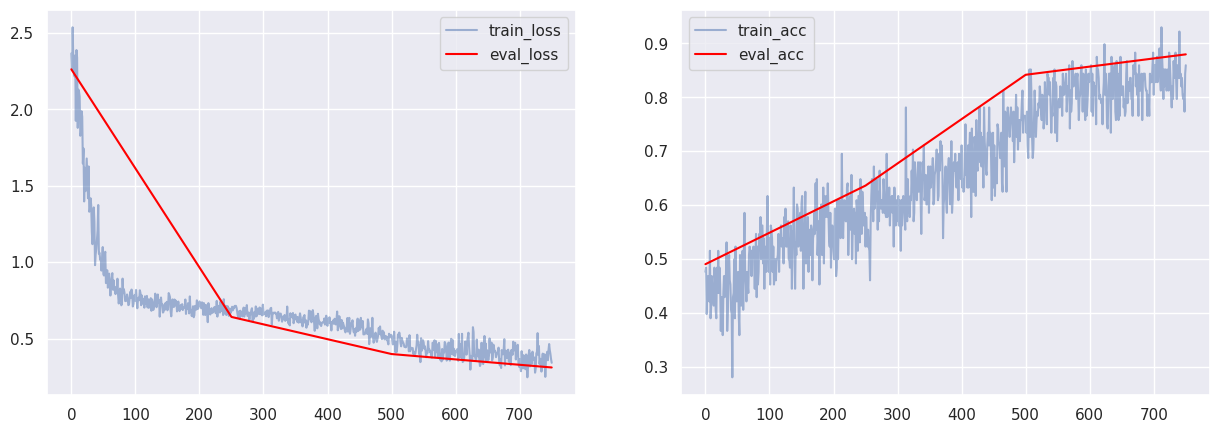

 36%|███▋      | 57/157 [03:15<05:43,  3.43s/it] 

CPU times: user 40min 56s, sys: 4.82 s, total: 41min 1s
Wall time: 41min 4s


In [19]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [20]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_acc}')

val loss: 0.30310394567087157
val acc: 0.8853210806846619


## Linear Probing

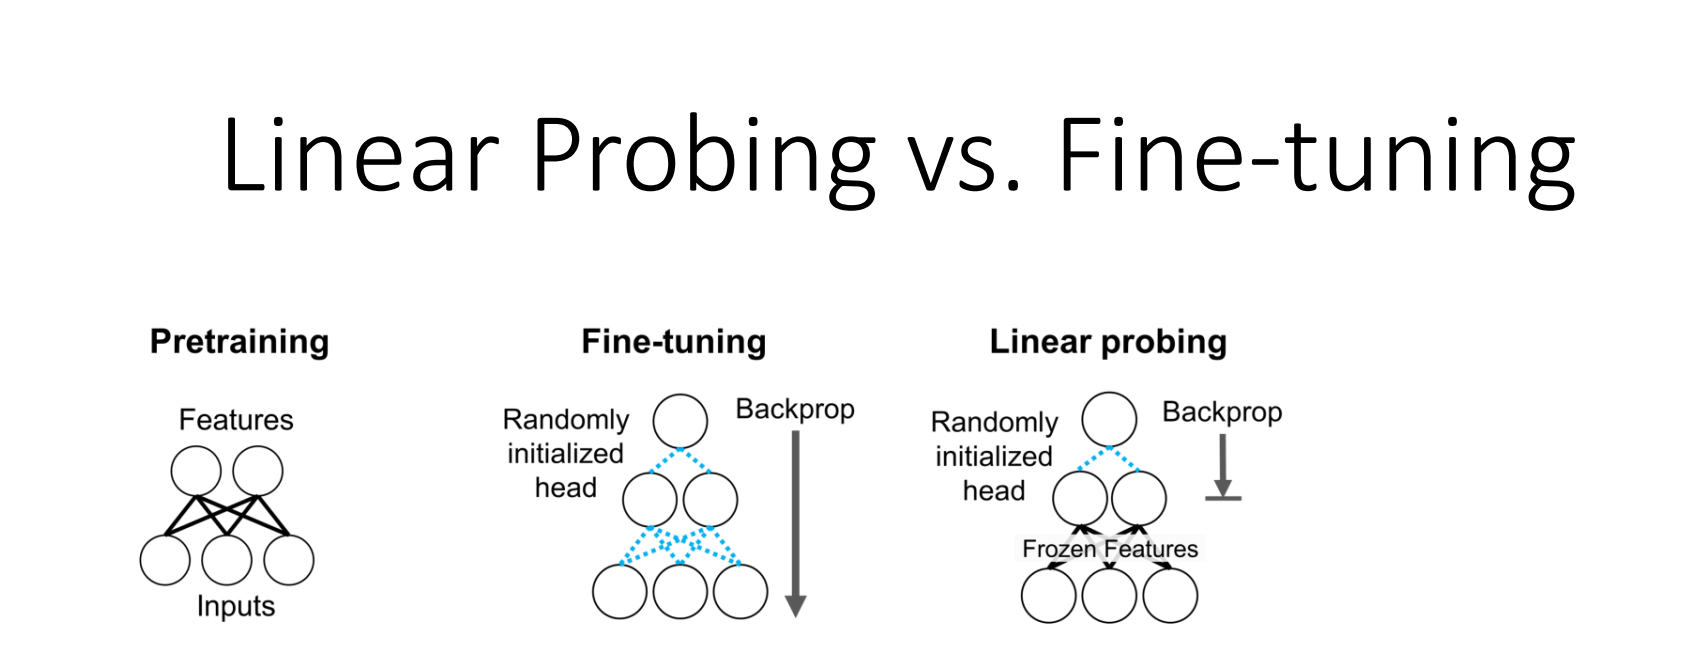

In [21]:
del model

In [22]:
torch.cuda.empty_cache()

In [23]:
model = Model(tokenizer, num_classes).to(device)
optimizer = AdamW(model.model.score.parameters(), lr=1e-4)

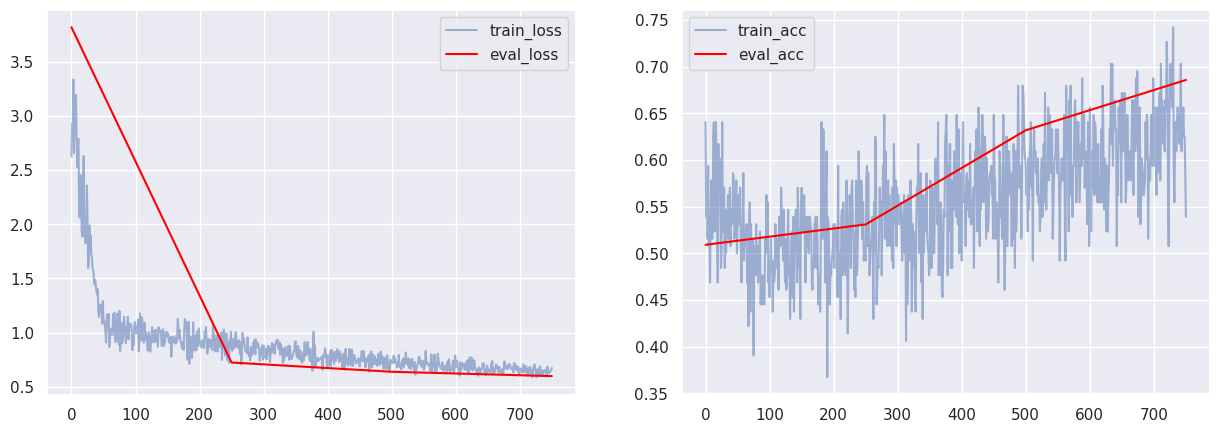

 36%|███▋      | 57/157 [01:28<02:35,  1.56s/it]

CPU times: user 37min 32s, sys: 5.42 s, total: 37min 38s
Wall time: 37min 40s


In [24]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [25]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f"val loss: {val_loss}")
print(f"val acc: {val_acc}")

val loss: 0.5761853139334863
val acc: 0.7052752375602722


In [26]:
torch.save(model.model.score.state_dict(), "head.pt")

## LoRa
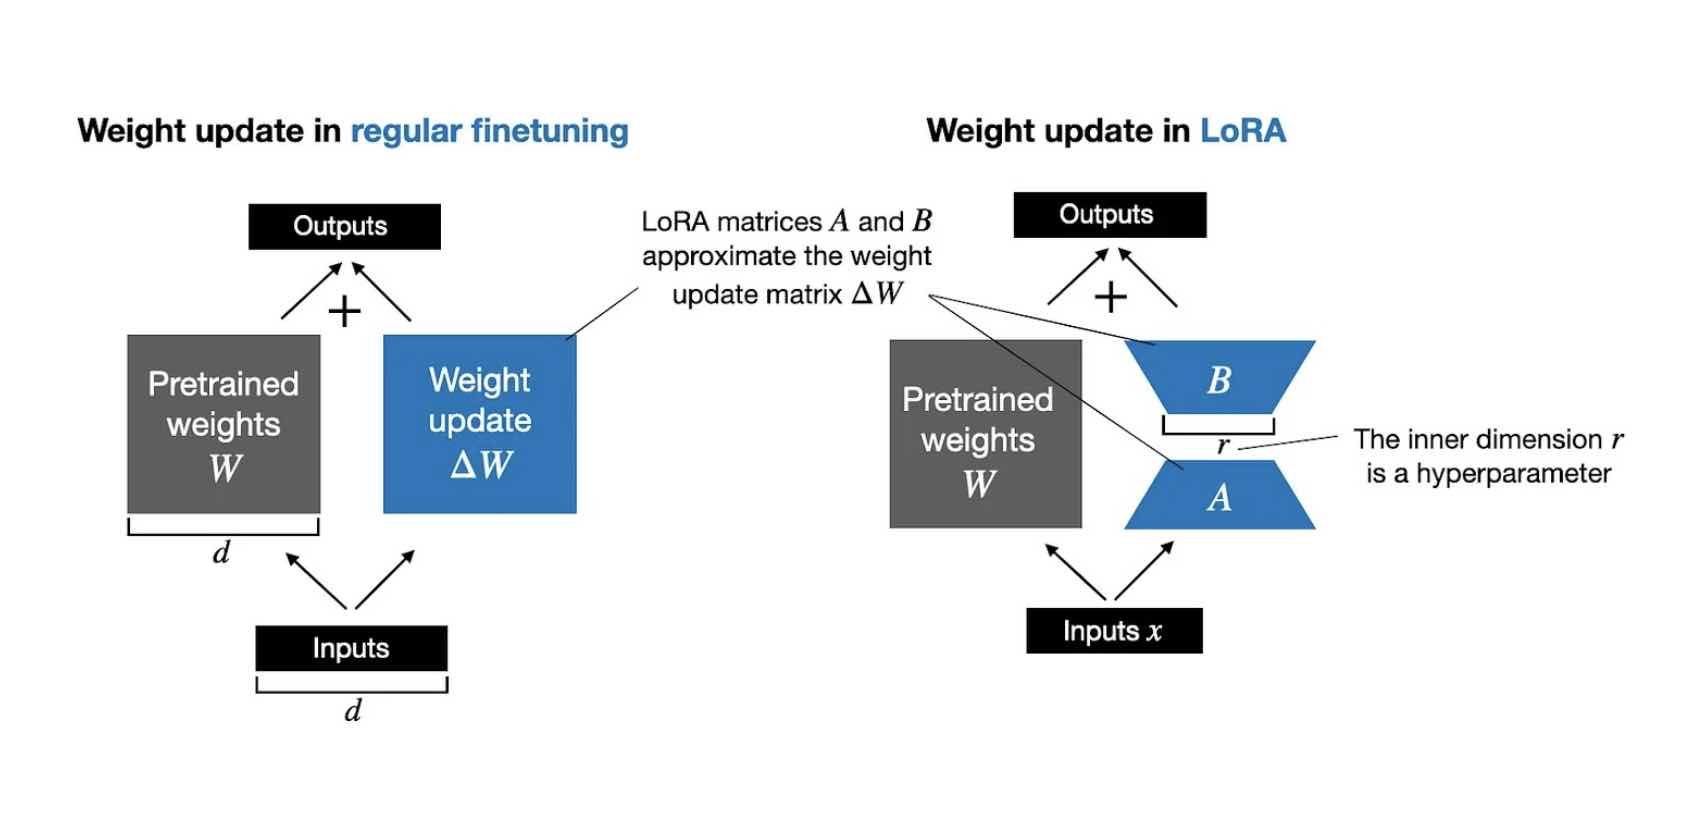


Самый важный параметр этой модели  – ранг матриц **A** и **B** (**r**). Его увеличение даёт больше степеней свободы в настройке добавки **AB**, повышая вместе с этим количество обучаемых параметров.


In [27]:
model

Model(
  (model): GPT2ForSequenceClassification(
    (transformer): GPT2Model(
      (wte): Embedding(50258, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (score): Linear(in_features=768, out_fea

In [28]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Тип задачи: классификация последовательностей
    inference_mode=False,  # False — будет обучение, True — только инференс
    r=8,  # Ранг матриц A и B: регулирует количество обучаемых параметров
    lora_dropout=0.1,  # Дропаут, применяемый к LoRA-адаптации
    target_modules=[
        "c_attn"
    ],  # Название слоя/модуля модели, к которому применяется LoRA
)

model = Model(tokenizer, num_classes).to(device)
lora_model = get_peft_model(model, peft_config).to(device)
lora_model.print_trainable_parameters()

trainable params: 296,448 || all params: 124,738,560 || trainable%: 0.2377


/home/dasha/work/testing/eval-env/lib/python3.9/site-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [29]:
sum(p.numel() for p in lora_model.parameters() if p.requires_grad)

296448

In [30]:
optimizer = AdamW(lora_model.parameters(), lr=1e-4)

In [31]:
torch.cuda.empty_cache()

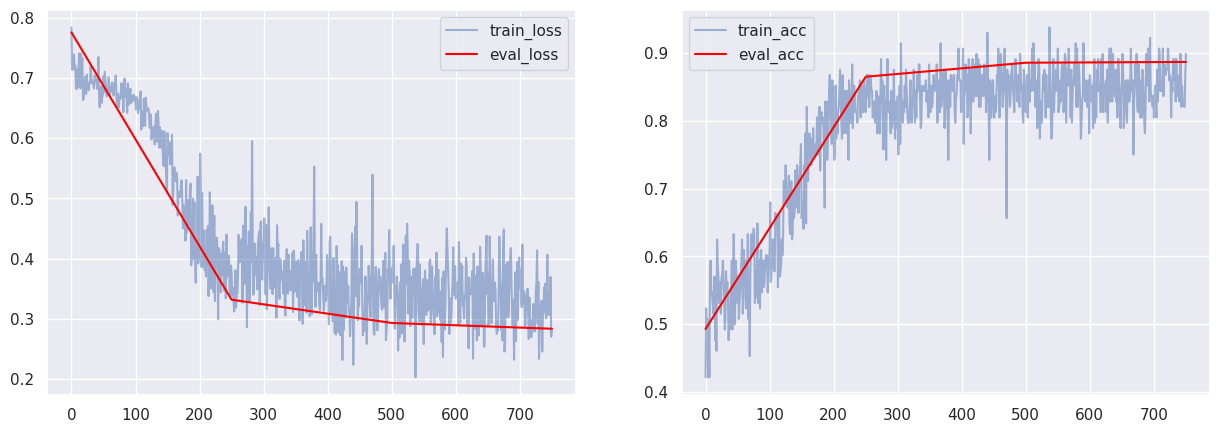

 36%|███▋      | 57/157 [01:00<01:45,  1.06s/it]

CPU times: user 18min 23s, sys: 5.03 s, total: 18min 28s
Wall time: 18min 31s


In [32]:
%%time
training_loop_fn(lora_model, optimizer, 1000, 250, train_loader, valid_loader)

In [33]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f"val loss: {val_loss}")
print(f"val acc: {val_acc}")

val loss: 0.2732224770642202
val acc: 0.8956422209739685


In [34]:
torch.save(lora_model.base_model.model.model.score.state_dict(), 'lora_head.pt')

- lora_model — это обёрнутая с помощью PEFT модель, в которую добавлены LoRA-адаптации.
- base_model — «базовая» модель внутри LoRA-обёртки (без LoRA-префиксов и адаптаций).
- model.model — иерархия внутри кастомной модели, где:
- первый .model — основная трансформер-модель (GPT2Model),
- второй .model — объект, содержащий классификационную голову.
- .score — финальный слой (например, nn.Linear), который выдаёт логиты классов.
- .state_dict() — словарь параметров (весов и смещений) этого слоя.

In [35]:
# head = MyHeadLayer()
# head.load_state_dict(torch.load("lora_head.pt"))

# lora_model.base_model.model.model.score.load_state_dict(torch.load("lora_head.pt"))

## LP-FT

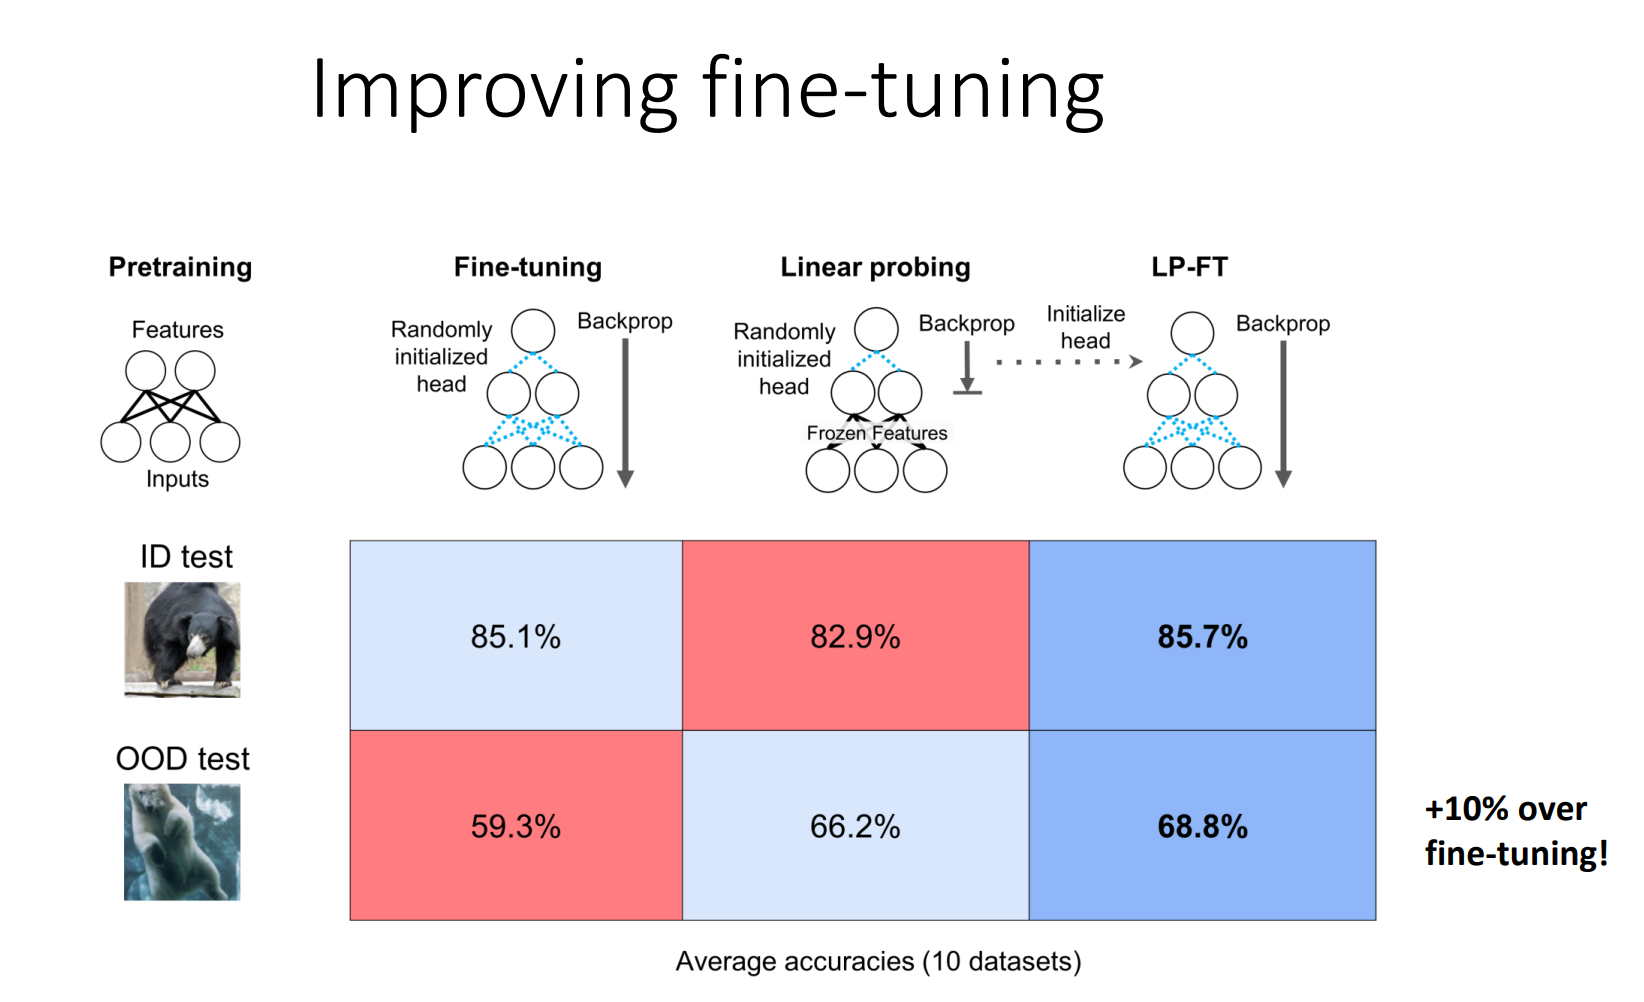

In [36]:
chkpt = torch.load('head.pt')
chkpt.keys()

odict_keys(['weight'])

In [37]:
chkpt

OrderedDict([('weight',
              tensor([[-0.0154,  0.0127, -0.0176,  ...,  0.0165, -0.0114,  0.0108],
                      [-0.0151, -0.0024,  0.0010,  ..., -0.0286, -0.0039, -0.0174]],
                     device='cuda:0'))])

In [38]:
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict(chkpt)
optimizer = AdamW(model.parameters(), lr=2e-6)

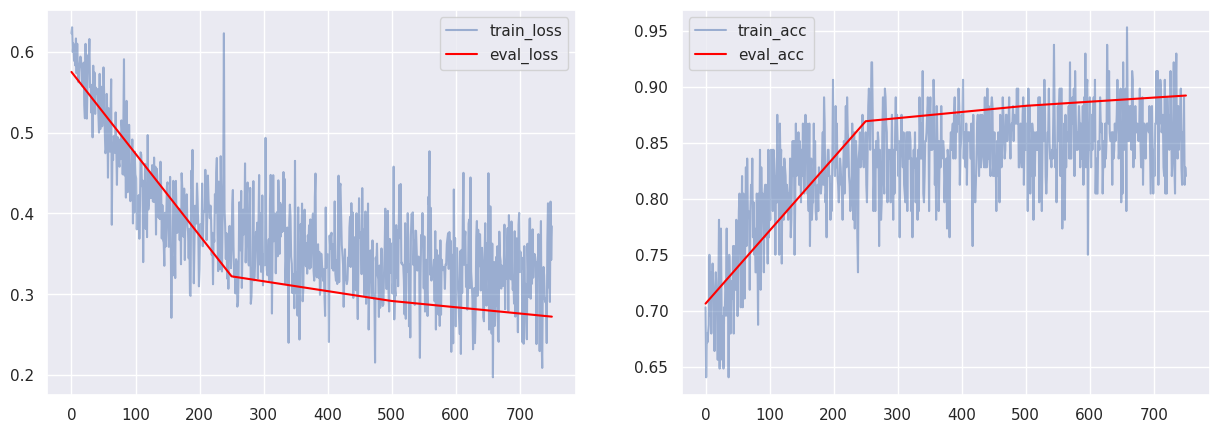

 36%|███▋      | 57/157 [03:31<06:11,  3.71s/it]

CPU times: user 56min 11s, sys: 5.38 s, total: 56min 16s
Wall time: 56min 15s


In [39]:
%%time
training_loop_fn(model, optimizer, 1000, 250, train_loader, valid_loader)

In [40]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f"val loss: {val_loss}")
print(f"val acc: {val_acc}")

val loss: 0.266403338231078
val acc: 0.8933486342430115


### Testing the model

In [41]:
@torch.no_grad()
def predict(text, target=0):
    tokenized = tokenizer(text, return_tensors="pt")
    for k, v in tokenized.items():
        tokenized[k] = v.to(device)

    logits = model(
        tokenized["input_ids"], tokenized["attention_mask"], return_dict=False
    )
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class_id = int(torch.argmax(logits, dim=-1))
    print(f"text: {text}")
    print(f"target: {target}, pred: {predicted_class_id}")
    print("probs:", probs.cpu().numpy())

In [42]:
predict('this movie is amazing', 1)

text: this movie is amazing
target: 1, pred: 1
probs: [[0.1251133 0.8748867]]


In [43]:
for i in range(10):
    text = valid_dataset[i]["sentence"]
    label = valid_dataset[i]['label']
    predict(text, label)
    print()

text: it 's a charming and often affecting journey . 
target: 1, pred: 1
probs: [[0.00199287 0.9980071 ]]

text: unflinchingly bleak and desperate 
target: 0, pred: 0
probs: [[0.87550116 0.12449884]]

text: allows us to hope that nolan is poised to embark a major career as a commercial yet inventive filmmaker . 
target: 1, pred: 1
probs: [[0.03669199 0.96330804]]

text: the acting , costumes , music , cinematography and sound are all astounding given the production 's austere locales . 
target: 1, pred: 1
probs: [[0.01018534 0.98981464]]

text: it 's slow -- very , very slow . 
target: 0, pred: 0
probs: [[0.9706095  0.02939056]]

text: although laced with humor and a few fanciful touches , the film is a refreshingly serious look at young women . 
target: 1, pred: 1
probs: [[0.01454026 0.98545974]]

text: a sometimes tedious film . 
target: 0, pred: 0
probs: [[0.9609143 0.0390857]]

text: or doing last year 's taxes with your ex-wife . 
target: 0, pred: 0
probs: [[0.87165064 0.12834938]


## Основные гиперпараметры LoRA

| Параметр         | Что означает                                      | Типичное значение       |
|------------------|---------------------------------------------------|--------------------------|
| `r`              | **Ранг матрицы** (размерность адаптера)           | `4`, `8`, `16`           |
| `lora_alpha`     | Коэффициент масштабирования (`α / r`)             | `16`, `32`, `64`         |
| `lora_dropout`   | Dropout перед LoRA                                 | `0.05`, `0.1`            |
| `bias`           | Обновлять ли смещения                              | `"none"`, `"lora_only"`, `"all"` |
| `target_modules` | В какие слои вставлять LoRA                        | `"c_attn"`, `"q_proj"`, `"v_proj"` |

---

## Рекомендации по выбору `r`

| `r`       | Использовать когда                                  | Примеры                    |
|-----------|------------------------------------------------------|----------------------------|
| `2`–`4`   | Модель небольшая, важна скорость                     | GPT2, DistilGPT2, BERT-mini |
| `8`       | Умеренный компромисс между качеством и экономией     | GPT2-Medium, BERT-base     |
| `16`      | Большие модели, нужен максимум качества              | LLaMA, BLOOM, T5-Large     |

> 📌 Чем выше `r`, тем больше обучаемых параметров → выше качество, но и ресурсы.

---

## Рекомендации по `lora_alpha`

- Обычно берут `α = 2 * r`, `4 * r`, иногда `8 * r`
- Это масштаб влияния LoRA-части на итоговый выход
- Если модель недообучает — увеличьте `alpha`

---

## Рекомендации по `lora_dropout`

- `0.05` — почти всегда оптимальное значение
- Если данных мало — можно увеличить до `0.1`
- Если данных много — можно уменьшить или отключить

---

## Практические комбинации

| Ситуация                           | Рекомендации                         |
|------------------------------------|--------------------------------------|
| Модель маленькая (GPT2-small)      | `r=4`, `alpha=16`, `dropout=0.05`    |
| Средняя модель (GPT2-medium, T5)   | `r=8`, `alpha=32`, `dropout=0.05`    |
| Минимальный адаптер                | `r=2`, `alpha=4`                     |
| Максимальное качество              | `r=16`, `alpha=64`, `dropout=0.05`   |

---

## Оценка числа параметров

Число обучаемых параметров:

```
LoRA-парам. ≈ r × (d_in + d_out)
```

Например, если `r=8` и слой `768→768`:

```
Параметров = 8 × (768 + 768) = 12,288
```

---

## Быстрый старт

Начни с «золотой середины»:

```python
r = 8
alpha = 32
lora_dropout = 0.05
bias = "none"
```
Подходит почти для всех задач на GPT, BERT и T5.
